# GHG emissions of global countries in a given year (in a treemap)

In [1]:
import os
import sys

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../"))


In [51]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify
import numpy as np

from data_analysis.eurostat_geo import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code
from data_analysis.eurostat_population_utils import get_eurostat_population_data


## Parameters

In [3]:
YEAR = 2022

# Don't convert svg texts to curves.
plt.rcParams['svg.fonttype'] = 'none'

## Fetch the data from EDGAR

In [4]:
edgar_ghg_path = '../../data/edgar/v8.0/EDGAR_AR5_GHG_1970_2022.xlsx'

edgar_cols = {
    'C_group_IM24_sh': 'geo',
    'Country_code_A3': 'code',
    'Name': 'country',
    'Y_2022': 'emissions'
}

edgar = pd.read_excel(edgar_ghg_path, sheet_name='TOTALS BY COUNTRY', header=9)
edgar = edgar[list(edgar_cols)].rename(columns=edgar_cols)

# Do not exclude international shipping and aviation
# edgar = edgar[~edgar['code'].isin(['SEA', 'AIR'])]

In [5]:
edgar.head()

,geo,code,country,emissions
0,Rest Central America,ABW,Aruba,496.682755
1,India +,AFG,Afghanistan,29117.879023
2,Southern_Africa,AGO,Angola,66480.057594
3,Rest Central America,AIA,Anguilla,28.098791
4,Int. Aviation,AIR,Int. Aviation,425963.735187


In [6]:
edgar['geo'].unique()

array(['Rest Central America', 'India +', 'Southern_Africa',
       'Int. Aviation', 'Central Europe', 'Middle_East',
       'Rest South America', 'Russia +', 'Oceania', 'OECD_Europe',
       'Eastern_Africa', 'Western_Africa', 'Ukraine +', 'Brazil',
       'Southeastern Asia', 'Canada', 'China +', 'Northern_Africa',
       'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Mexico',
       'Int. Shipping', 'USA', 'Turkey'], dtype=object)

## Import global population data from UN

In [7]:
un_population_path = '../../data/un/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx'
un_cols = {
    'ISO3 Alpha-code': 'code',
    'Year': 'year',
    'Total Population, as of 1 July (thousands)': 'population'
}

un_pop = pd.read_excel(un_population_path, sheet_name='Estimates', header=16)
un_pop = un_pop[list(un_cols)].rename(columns=un_cols)
un_pop.head()

,code,year,population
0,NaN,1950.0,2499322.157
1,NaN,1951.0,2543130.38
2,NaN,1952.0,2590270.899
3,NaN,1953.0,2640278.797
4,NaN,1954.0,2691979.339


In [8]:
un_pop = un_pop.dropna().loc[un_pop['year'] == 2021]
un_pop['population'] = un_pop['population'].apply(lambda x: x*1000)
un_pop = un_pop.drop('year', axis=1)
un_pop.head()

,code,population
1803,BDI,12551213.0
1875,COM,821625.0
1947,DJI,1105557.0
2019,ERI,3620312.0
2091,ETH,120283026.0


## Merge data from UN and EDGAR to get population-based emission stats

In [9]:
emissions = pd.merge(edgar, un_pop, on='code')
emissions

,geo,code,country,emissions,population
0,Rest Central America,ABW,Aruba,496.682755,106537.0
1,India +,AFG,Afghanistan,29117.879023,40099462.0
2,Southern_Africa,AGO,Angola,66480.057594,34503774.0
3,Rest Central America,AIA,Anguilla,28.098791,15753.0
4,Central Europe,ALB,Albania,7983.378894,2854710.0
...,...,...,...,...,...
214,Oceania,WSM,Samoa,548.424096,218764.0
215,Middle_East,YEM,Yemen,38006.043126,32981641.0
216,Southern_Africa,ZAF,South Africa,534531.651545,59392255.0
217,Southern_Africa,ZMB,Zambia,30330.585040,19473125.0


In [10]:
geo_map = {
    'Africa': ['Southern_Africa', 'Eastern_Africa', 'Western_Africa', 'Northern_Africa'],
    'Europe': ['Central Europe', 'Russia +', 'OECD_Europe', 'Ukraine +'],
    'Asia': ['India +', 'Middle_East', 'Southeastern Asia', 'China +', 'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Turkey'],
    'NAmerica': ['Canada', 'USA', 'Mexico'],
    'SCAmerica': ['Rest Central America', 'Rest South America', 'Brazil'],
    'Oceania': ['Oceania']
}

geo_map_flat = {y: x for x in geo_map for y in geo_map[x]}

eu_sum = emissions.loc[emissions['geo'].isin(geo_map['Europe'])].sum()
africa_sum = emissions.loc[emissions['geo'].isin(geo_map['Africa'])].sum()
asia_sum = emissions.loc[emissions['geo'].isin(geo_map['Asia'])].sum()
na_sum = emissions.loc[emissions['geo'].isin(geo_map['NAmerica'])].sum()
sca_sum = emissions.loc[emissions['geo'].isin(geo_map['SCAmerica'])].sum()
oce_sum = emissions.loc[emissions['geo'].isin(geo_map['Oceania'])].sum()

emissions['geo_group'] = emissions['geo'].map(geo_map_flat)
emissions

,geo,code,country,emissions,population,geo_group
0,Rest Central America,ABW,Aruba,496.682755,106537.0,SCAmerica
1,India +,AFG,Afghanistan,29117.879023,40099462.0,Asia
2,Southern_Africa,AGO,Angola,66480.057594,34503774.0,Africa
3,Rest Central America,AIA,Anguilla,28.098791,15753.0,SCAmerica
4,Central Europe,ALB,Albania,7983.378894,2854710.0,Europe
...,...,...,...,...,...,...
214,Oceania,WSM,Samoa,548.424096,218764.0,Oceania
215,Middle_East,YEM,Yemen,38006.043126,32981641.0,Asia
216,Southern_Africa,ZAF,South Africa,534531.651545,59392255.0,Africa
217,Southern_Africa,ZMB,Zambia,30330.585040,19473125.0,Africa


Aggregate geographical groups 

In [58]:
def create_geo_aggregations(df, arr):
    # name, include_geo_groups, include_codes, exclude_codes
    geo_group_emissions = []
    for item in arr:
        geo_group_emissions.append([
            item['name'],
            df.loc[df['geo_group'].isin(item['include_geo_groups'])]['emissions'].sum()
            + df.loc[df['code'].isin(item['include_codes'])]['emissions'].sum()
            - df.loc[df['code'].isin(item['exclude_codes'])]['emissions'].sum(),
            df.loc[emissions['geo_group'].isin(item['include_geo_groups'])]['population'].sum()
            + df.loc[df['code'].isin(item['include_codes'])]['population'].sum()
            - df.loc[df['code'].isin(item['exclude_codes'])]['population'].sum()
        ])
    return geo_group_emissions

geo_group_emissions_array = create_geo_aggregations(
    emissions,
    [
        {'name': 'Europe', 'include_geo_groups': ['Europe'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'Asia', 'include_geo_groups': ['Asia'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'Africa', 'include_geo_groups': ['Africa'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'NAmerica', 'include_geo_groups': ['NAmerica'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'SCAmerica', 'include_geo_groups': ['SCAmerica'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'Oceania', 'include_geo_groups': ['Oceania'], 'include_codes': [], 'exclude_codes': []},
        {'name': 'Europe w/o Russia', 'include_geo_groups': ['Europe'], 'include_codes': [], 'exclude_codes': ['RUS']},
        {'name': 'EU', 'include_geo_groups': [], 'include_codes': ['RUS'], 'exclude_codes': ['RUS']},
        {'name': 'Asia w/o China, India', 'include_geo_groups': ['Asia'], 'include_codes': [], 'exclude_codes': ['CHN', 'IND']},
        {'name': 'China', 'include_geo_groups': [], 'include_codes': ['CHN'], 'exclude_codes': []},
        {'name': 'India', 'include_geo_groups': [], 'include_codes': ['IND'], 'exclude_codes': []},
        {'name': 'USA', 'include_geo_groups': [], 'include_codes': ['USA'], 'exclude_codes': []},
        {'name': 'NAmerica w/o USA', 'include_geo_groups': ['NAmerica'], 'include_codes': [], 'exclude_codes': ['USA']}
    ]
)

columns = ['id', 'emissions', 'population']
geo_group_emissions = pd.DataFrame(geo_group_emissions_array, columns=columns)
geo_group_emissions

,id,emissions,population
0,Europe,7.181963e+06,7.533035e+08
1,Asia,3.080705e+07,4.681286e+09
2,Africa,3.413584e+06,1.382928e+09
3,NAmerica,7.594170e+06,5.018637e+08
4,SCAmerica,2.873712e+06,5.291532e+08
5,Oceania,6.676793e+05,3.454229e+07
6,Europe w/o Russia,4.602165e+06,6.082008e+08
7,EU,0.000000e+00,0.000000e+00
8,"Asia w/o China, India",1.117916e+07,1.847829e+09
9,China,1.568463e+07,1.425893e+09


Run calculations for per-capita and percentage ghg emissions

In [59]:
total_emissions=geo_group_emissions['emissions'].sum()
geo_group_emissions['em_per_capita'] = (geo_group_emissions['emissions'] * 1000000) / geo_group_emissions['population']
geo_group_emissions['em_per_cent'] = (geo_group_emissions['emissions'] * 100) / total_emissions
geo_group_emissions['emissions_summary'] = \
    geo_group_emissions['emissions'].apply(czech_float) + \
    " (" + geo_group_emissions['em_per_cent'].apply(czech_float) + "%)"
geo_group_emissions.sort_values('emissions', ascending=False, inplace=True)
geo_group_emissions

,id,emissions,population,em_per_capita,em_per_cent,emissions_summary
1,Asia,3.080705e+07,4.681286e+09,6580.894156,32.244664,"30 807 048,2 (32,2%)"
9,China,1.568463e+07,1.425893e+09,10999.858790,16.416552,"15 684 626,8 (16,4%)"
8,"Asia w/o China, India",1.117916e+07,1.847829e+09,6049.887854,11.700834,"11 179 156,8 (11,7%)"
3,NAmerica,7.594170e+06,5.018637e+08,15131.938678,7.948553,"7 594 170,1 (7,9%)"
0,Europe,7.181963e+06,7.533035e+08,9533.955947,7.517110,"7 181 962,9 (7,5%)"
11,USA,6.017443e+06,3.369976e+08,17856.039790,6.298248,"6 017 443,0 (6,3%)"
6,Europe w/o Russia,4.602165e+06,6.082008e+08,7566.850998,4.816925,"4 602 164,8 (4,8%)"
10,India,3.943265e+06,1.407564e+09,2801.481874,4.127278,"3 943 264,6 (4,1%)"
2,Africa,3.413584e+06,1.382928e+09,2468.374201,3.572880,"3 413 584,2 (3,6%)"
4,SCAmerica,2.873712e+06,5.291532e+08,5430.775008,3.007814,"2 873 712,2 (3,0%)"


## Plot the graphs

In this section, the prepared dataset is used for two subgraphs

### Code for creating the subgraphs

In [12]:
def _draw_treemap_plot(year, df):
    # Define colors using a colormap.
    cmap = matplotlib.cm.viridis
    mini = min(df['emissions'])
    maxi = max(df['emissions'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df['emissions']]

    # Make the figure a bit larger to accommodate a complex graph.
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 2.5, 2.5])

    # Produce rectangles using squarify (first normalizing data).
    sizes = df['emissions']
    norm_x = norm_y = 100
    normed = squarify.normalize_sizes(sizes, norm_x, norm_y)
    rects = squarify.squarify(normed, 0, 0, norm_x, norm_y)

    # Squarify puts the largest square on the bottom left. The resulting graph should have it on
    # the top left, thus flip the y-axis.
    for rect in rects:
        rect["y"] = norm_y - rect["y"] - rect["dy"]

    ax.bar([rect["x"] for rect in rects], [rect["dy"] for rect in rects],
           width=[rect["dx"] for rect in rects], bottom=[rect["y"] for rect in rects],
           color=colors, label=df["country"], align="edge")

    # Print the labels of countries and their emission summary
    countries = df["country"]
    pad_x = 0.5
    pad_y = 1
    for l, r in zip(countries, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l,
                va="top", ha="left", color="white", fontsize=12, fontweight="bold")

    emissions = df["emissions_summary"]
    pad_y = 4
    for l, r in zip(emissions, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l, va="top",
                ha="left", color="white", fontsize=12)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    plt.title(
        f"Celkové roční emise států EU za rok {year} v milionech tun CO2 ekv.")
    plt.axis("off")

    plt.savefig("output-EU-treemap.svg")
    plt.show()
    plt.clf()


In [13]:
def _draw_barh_plot(year, df):
    fig = plt.figure(figsize=(5,10))
    df_sorted = df.sort_values(by='em_per_capita', ascending=True)
    plt.barh(df_sorted.index, df_sorted['em_per_capita'], color="lightsteelblue")

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_sorted.index, [0] * df_sorted.index.size)
    # Add emission value labels on the left.        
    plt.bar_label(fake_bar, labels=[czech_float(x) for x in df_sorted['em_per_capita']], padding=-30, fontsize=9)
    # Add country name labels on the right.
    plt.bar_label(fake_bar, labels=df_sorted["country"], padding=3, fontsize=10)

    plt.title(f'Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU za rok {year}.')
    plt.axis("off")

    plt.savefig("output-EU-bars.svg")

### Plot the graphs and export them as SVG

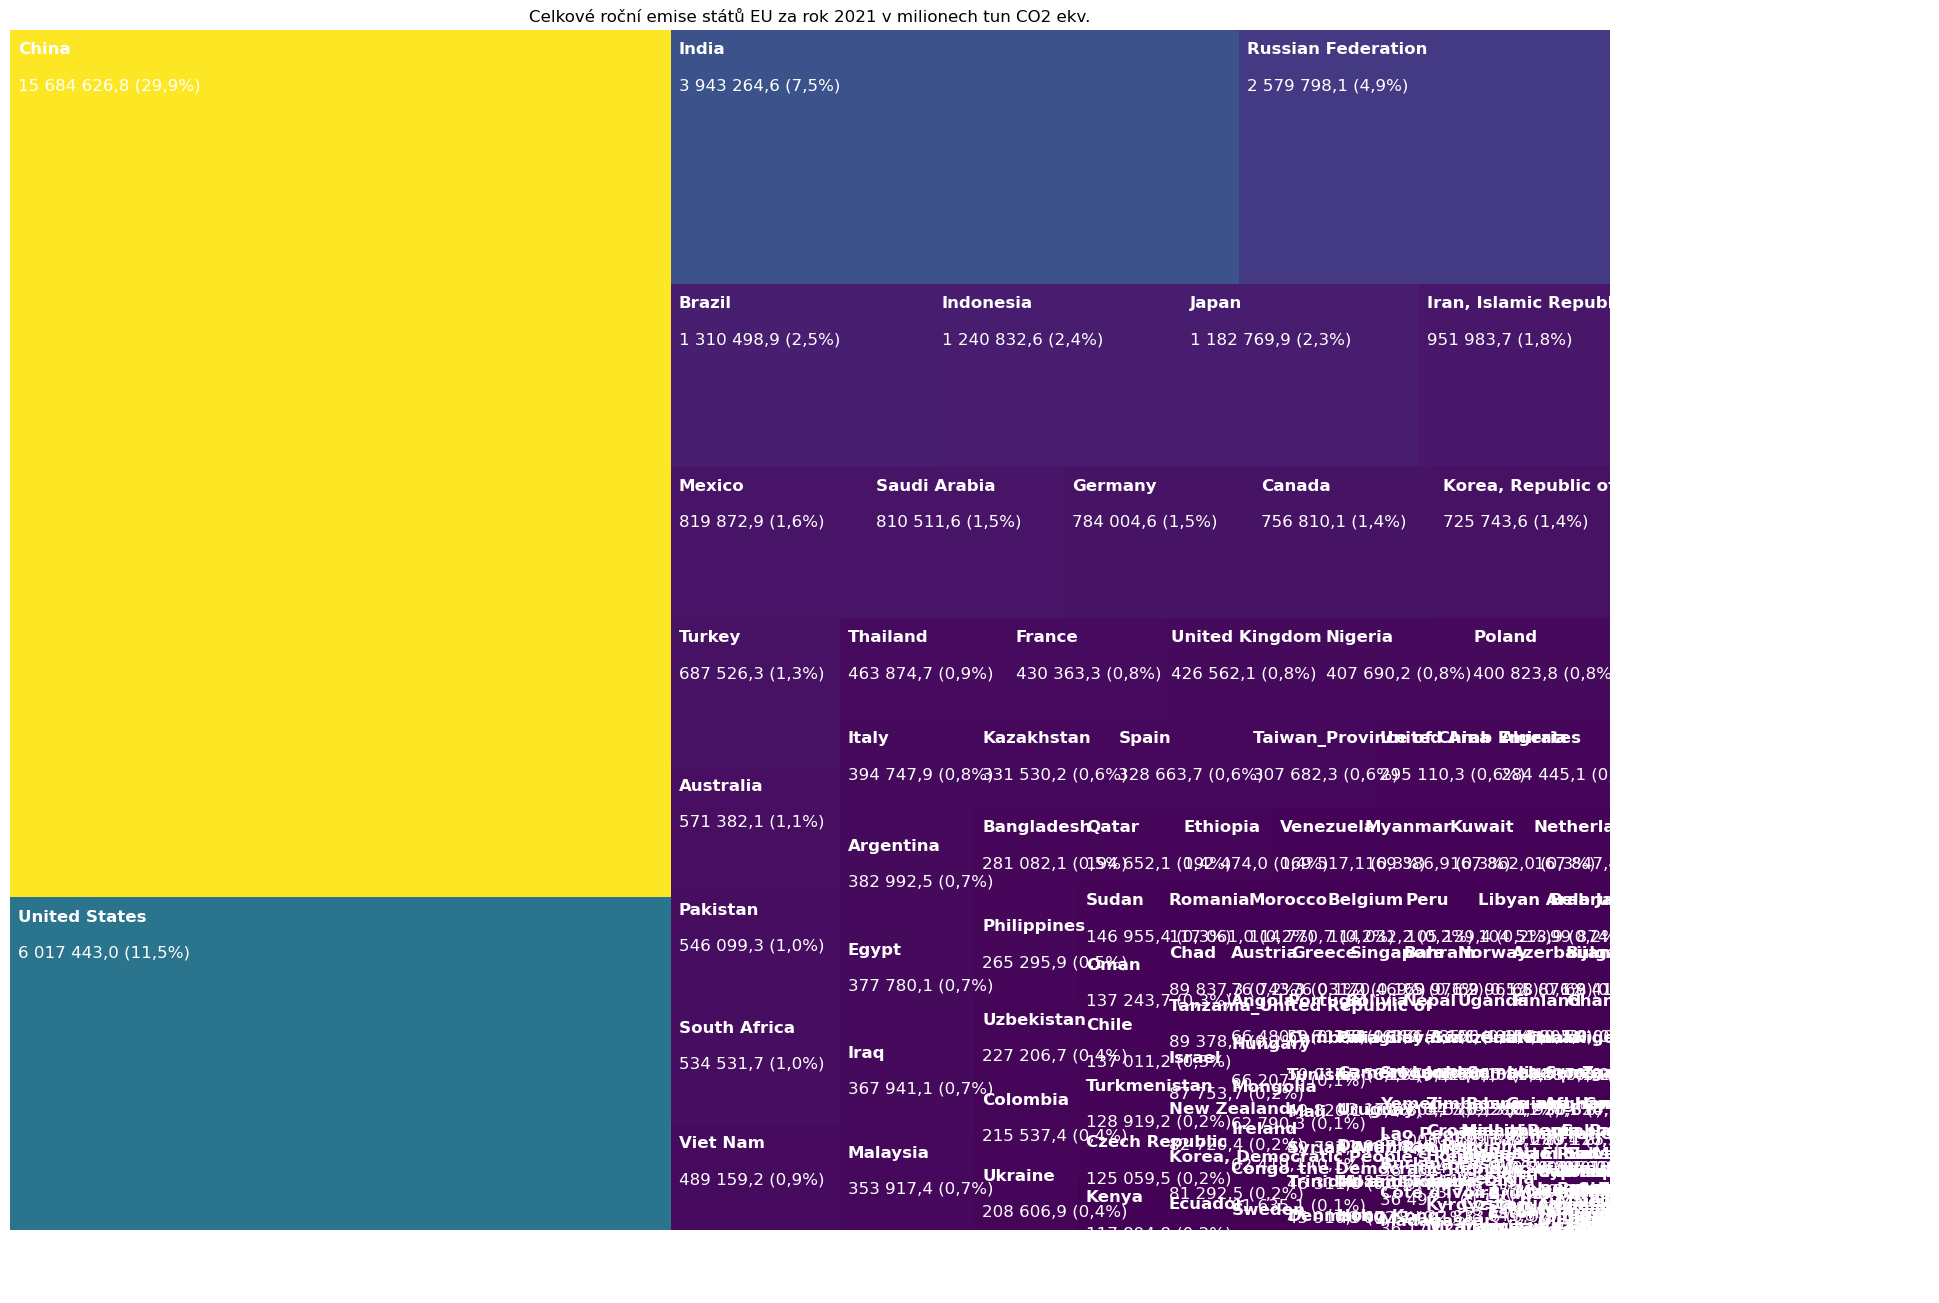

<Figure size 640x480 with 0 Axes>

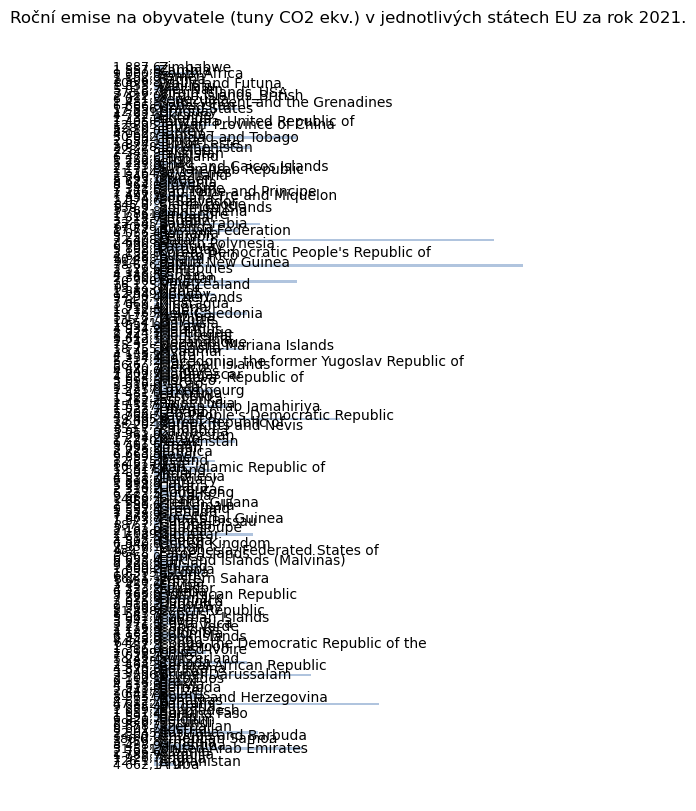

In [14]:
# draw plots
_draw_treemap_plot(YEAR, emissions)
_draw_barh_plot(YEAR, emissions)

## Generate accompanying text for the web

First, helper functions making use of the dataset are defined.

In [ ]:
def _get_population_in_mio(geo: Geo, decimals: int = 1) -> str:
    return czech_float(df.loc[geo.value, "population"] / 1_000_000, decimals=decimals)


def _get_emissions(geo: Geo) -> str:
    return czech_float(df.loc[geo.value, "emissions"])


def _get_order(geo: Geo) -> str:
    return df.loc[geo.value, "order"]


def _get_top_list() -> str:
    output = ""
    for index, row in df.head(4).iterrows():
        output += f"""
* {row["country"]} se svými cca {czech_float(row["population"] / 1_000_000, 0)} mil. obyvateli: {czech_float(row["emissions"])} mil. t CO<sub>2</sub>eq"""
    return output


#### Fact check statements from the text

Update the statements if they are no more correct!

In [ ]:
print(f"""
Is population of Czechia similar as population of Sweden?
- CZ: {_get_population_in_mio(Geo.CZ)} M
- SE: {_get_population_in_mio(Geo.SE)} M""")

print(f"""
Are emissions per capita of Czechia still more than 2x of emissions per capita of Sweden?
- CZ: {df.loc[Geo.CZ.value, "em_per_capita"].round(2)} t
- SE: {df.loc[Geo.SE.value, "em_per_capita"].round(2)} t
- SEx2: {df.loc[Geo.SE.value, "em_per_capita"].round(2) * 2} t""")

print(f"""
Are the top emitters per capita still the same?
- 1. LU: real order: {_get_order(Geo.LU)}
- 2. IE: real order: {_get_order(Geo.IE)}
- 3. CZ: real order: {_get_order(Geo.CZ)}""")


In [ ]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů států EU"
slug:       "emise-eu"
redirect_from: "/emise-eu"
published:  2019-08-22
weight:     95
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Poměrové srovnání ročních emisí 27 členských států EU a přepočet na obyvatele."
data-orig:  [["Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions/treemap-EU.ipynb"]]
---

## Jak číst tento graf?

{get_gases_info()}

{{% include preview-box.html
    title="Jak jsou emise rozdělené mezi světové regiony?"
    text="Obdobnou infografiku jsme vytvořili i pro celosvětové emise skleníkových plynů."
    slug="emise-svet"
%}}

V levé části jsou celkové roční emise členských států EU za rok {YEAR} v mil. tun CO<sub>2</sub>eq, vč. procentuálního zastoupení. Plocha zabraná konkrétním státem odpovídá poměru vůči celku.

Největší státy EU (jak [z hlediska počtu obyvatel](https://en.wikipedia.org/wiki/List_of_European_Union_member_states_by_population), tak [z hlediska HDP](https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(nominal))) mají v absolutních číslech nejvyšší emise:
{_get_top_list()}

Česká republika jako stát s cca {_get_population_in_mio(Geo.CZ)} mil. obyvateli a emisemi {_get_emissions(Geo.CZ)} mil. t CO<sub>2</sub>eq __je v přepočtu na obyvatele {_get_order(Geo.CZ)}. největším emitentem EU__ a má více než 2× vyšší emise než stejně velké Švédsko (cca {_get_population_in_mio(Geo.SE)} mil. obyvatel).

## Zajímavosti a komentáře k ročním emisím na obyvatele

* Lucembursko, které je v přepočtu na obyvatele na prvním místě, má [dle platformy Votum Klima](https://today.rtl.lu/news/luxembourg/a/1184731.html) tak vysoké emise kvůli nafto-benzínovému turismu (5× vyšší než průměr EU)
* Irsko, na druhém místě, má velmi vysoký podíl zemědělské produkce (skoro 5× vyšší než průměr EU)
* Česko, na třetím místě, má velmi vysoký podíl špinavé energetiky (2× vyšší než průměr EU, zejména vlivem hnědouhelných elektráren) - viz naše  [související infografika](/infografiky/emise-cr-detail).

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(None)}
'''
print(accompanying_text)
